## **Osnovni koncepti**

### **NMF**
NMF (Non-negative Matrix Factorization) nastoji dekomponirati matricu **X** u dva  nižerangirana nenegativna faktora **U** i **V**. Ta dekompozicija pokušava predstaviti originalnu matricu podataka **X** kao linearnu kombinaciju baznih vektora pohranjenih u **U** na koje utječu koeficijenit matrice **V**.

Aproksimacija izgleda ovako: $ X \approx UV^T $


### **Funckija troška**
Kao u strojnom učenju, funkcija troška ovisi o konkretnom problemu i svojstvima podataka. Dvije često korištene funkcije troška su:

1. **Frobeniusova norma (Kvadrirana Euklidska Udaljenost):**
$ \text{cost}(X, UV^T) = \frac{1}{2} \sum_{i,j} (X_{ij} - (UV^T)_{ij})^2 $

2. **Kullback-Leibler (KL) divergencija:**
$ \text{cost}(X, UV^T) = \sum_{i,j} (X_{ij} \log \frac{X_{ij}}{(UV^T)_{ij}} - X_{ij} + (UV^T)_{ij}) $


### **Pojam optimizacije**
Cilj postupka NMF je pronaći optimalne vrijednosti za  $ U $ i $ V^T $ koje minimiziraju odabranu funkciju troška.
Optimizacijski problem obično se rješava pomoću iterativnih algoritama poput multiplikativnih ažuriranja, alternativnih najmanjih kvadrata (ALS) ili stohastičkog gradijentnog spusta (SGD). (Algoritmi itereativno ažuriraju vrijednosti $ U $ i $ V^T $ do konvergencije lokalnom minimumu funkcije troška)

### **Prednosti**
- Prirodno rukovanje nenegativnim podacima
- Proizvodi dijeljenje reprezentacije
- Može uhvatiti složene strukture i obrasce u podacima.

### **Nedostatci**
- Osjetljivost na inicijalizaciju
- Računalna složenost, pogotovo za velike matrice.
- Može zahtijevati pažljivo podešavanje hiperparametara.




## **NMF u kontekstu grupiranja dokumenata**

### **Reprezentacija dokumenata**
- Skupljeni korpus dokumenata pretvoren je u vektore, pri čemu je svaki dokument predstavljen kao vektor frekvencija pojmova. Svaki element pojedinog vektora predstavlja frekvenciju određenog pojma (riječi) u dokumentu.
- Vektori su rijetki i nenegativni, pogodni za NMF metodu

### **Dekompozicija**
 - Matrica pojmova-dokumenata, gdje svaki stupac predstavlja dokument, a svaki redak predstavlja pojam, faktorizirana je u dva nenegativna faktora: $ U $ i $ V^T $.
   - $ U $ sadrži bazne vektore ili latentne teme, predstavljajući osnovne teme ili koncepte u korpusu dokumenata.
   - $ V^T $ sadrži koeficijente, koji označavaju doprinos svake teme svakom dokumentu.

### **Interpretacija Faktora:**
   - Bazni vektori u $ U $ predstavljaju latentne teme ili teme u korpusu dokumenata. Svaki bazni vektor je distribucija pojmova u rječniku, što ukazuje na važnost svakog pojma u toj temi.
   - Koeficijenti u $ V^T $ specificiraju kako je svaki dokument sastavljen od ovih latentnih tema. Svaki dokument je predstavljen kao mješavina tema, pri čemu koeficijenti ukazuju na jakost povezanosti s pojedinom temom.

### **Klasteriranje**
   - Kada su matrice $ U $ i $ V^T $ dobivene, klasteriranje se može provesti pomoću različitih metoda. Jedan uobičajeni pristup je korištenje matrice dokumenata-tema $ V^T $ za klasteriranje.
   - Svaki redak u $ V^T $ odgovara jednom dokumentu, a algoritam klasteriranja dodjeljuje dokumente u klasterima na temelju njihove sličnosti u latentnom prostoru tema.
   - Dokumenti koji imaju slične distribucije tema bit će grupirani zajedno u isti klaster, što omogućuje otkrivanje koherentnih tema u korpusu.

### **Prednosti NMF-a u Klasteriranju Dokumenata**
   - NMF proizvodi interpretabilne reprezentacije dokumenata i tema, olakšavajući razumijevanje osnovne strukture korpusa.
   - Prirodno rukuje inherentnom rijetkošću i nenegativnošću matrica dokumenata-pojava.
   - NMF može uhvatiti složene odnose i preklapajuće teme u korpusu dokumenata, pružajući značajnije klasteriranje u usporedbi s tradicionalnim metodama.
   - Fokusiranjem na nenegativne faktore, NMF osigurava da rezultirajuće teme i reprezentacije dokumenata budu intuitivne i semantički smislene.

### 0. We import the necessary packages.

In [1]:
import numpy as np
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### 1. We define a function to calculate weighted term-frequency matrix.


In [2]:
def calculate_weighted_tfidf(documents):
    # Step 1: Create a vocabulary from the document corpus
    all_words = []
    for doc in documents:
        words = doc.split()
        all_words.extend(words)
    vocabulary = np.unique(all_words)
    n_terms = len(vocabulary)
    n_docs = len(documents)

    # Initialize tf and df
    tf = np.zeros((n_terms, n_docs))
    df = np.zeros(n_terms)

    # Step 2: Calculate term frequency (tf) and document frequency (df)
    for j, doc in enumerate(documents):
        words = doc.split()
        for i, term in enumerate(vocabulary):
            tf[i, j] = words.count(term)
            if tf[i, j] > 0:
                df[i] += 1

    # Step 3: Calculate inverse document frequency (idf)
    idf = np.log(n_docs / df)

    # Step 4: Calculate weighted term-frequency matrix X
    X = np.zeros((n_terms, n_docs))
    for i in range(n_terms):
        for j in range(n_docs):
            X[i, j] = tf[i, j] * idf[i]

    # Normalize columns of X to unit Euclidean length
    X = X / np.sqrt(np.sum(X**2, axis=0))

    return X

### 2. We define example documents, or load documents, and calculate weighted term-frequency matrix X.

In [3]:
# Example set of documents
documents = [
    "The cat sat on the mat and looked around. It seemed content in its cozy spot.",
    "The dog chased the cat all around the yard, barking loudly as it ran.",
    "The cat climbed the tall tree, its agile movements a sight to behold.",
    "A group of birds chirped merrily as they flew over the green fields.",
    "The sun shone brightly in the clear blue sky, warming everything it touched.",
    "The flowers bloomed in a riot of colors, painting the landscape with beauty.",
    "Children laughed and played in the park, their joy infectious to all who watched.",
    "The old oak tree stood tall and proud, its branches reaching up to the heavens.",
    "A gentle breeze rustled the leaves, whispering secrets to those who listened.",
    "The river flowed peacefully, its waters sparkling in the sunlight.",
    "As night fell, the stars appeared one by one, lighting up the dark sky with their brilliance.",
    "The moon cast its silver light over the land, bathing everything in a soft, ethereal glow."
]

import os

def load_documents_from_files(folder_path):
    documents = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):  # Assuming documents are text files
            with open(os.path.join(folder_path, file_name), 'r') as file:
                documents.append(file.read())
    return documents

folder_path = 'path/to/your/documents/folder'

#documents = load_documents_from_files(folder_path)

### 3. We calculate the matrix X and perform NMF on it to get U and V.

In [4]:
# Calculate weighted term-frequency matrix X
X = calculate_weighted_tfidf(documents)

# Perform NMF on X to obtain U and V
k = 3  # Number of clusters (topics)
model = NMF(n_components=k, init='random', random_state=0, max_iter=500)
U = model.fit_transform(X)
V = model.components_

### 4. We normalize the U and V matrices and use V to determine labels for each document

In [5]:
# Normalize U and V
for j in range(k):
    norm_factor = np.linalg.norm(U[:, j])
    U[:, j] /= norm_factor
    V[j, :] *= norm_factor

# Use matrix V to determine the cluster label of each document
cluster_labels = np.argmax(V, axis=0)

### 5. We display the cluster labels.

Cluster labels for each document:
[2 0 2 0 0 0 1 2 1 2 1 0]


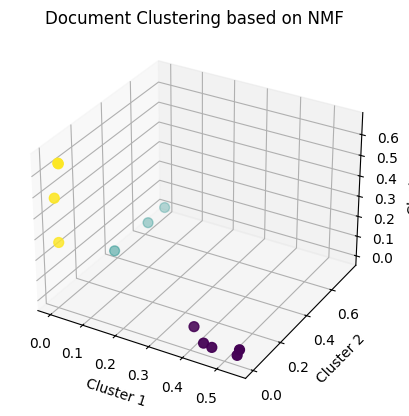

In [6]:
# Display the cluster labels
print('Cluster labels for each document:')
print(cluster_labels)

# Visualize the clustering result
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(V[0, :], V[1, :], V[2, :], c=cluster_labels, cmap='viridis', s=50)
ax.set_title('Document Clustering based on NMF')
ax.set_xlabel('Cluster 1')
ax.set_ylabel('Cluster 2')
ax.set_zlabel('Cluster 3')
plt.show()